# Table of Contents
1. [Step 1: Gather the Data](#step1)
1. [Step 2: Prepare Data for Consumption](#step2)
   - [2.1 Import Libraries](#step2.1)
   - [2.1 Meet The Data](#step2.2)
   - [2.3 Clean Data](#step2.3)
   - [2.4 Convert Formats](#step2.4)
1. [Step 3: Visualization](#step3)

<a id="step1"></a>
# Step 1: Gather the Data
The data collected and created at create_ds.ipynb script

<a id="step2"></a>
# Step 2: Prepare Data for Consumption

<a id="step2.1"></a>
## 2.1 Import Libraries

In [1]:
import sys
print("Python version: {}". format(sys.version))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
print("SciPy version: {}". format(sp.__version__)) 

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
print("ipywidgets version: {}". format(widgets.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))
%matplotlib inline

pd.set_option('display.max_columns', None)
sns.set(style='white', context='notebook', palette='deep')

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Python version: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 19:29:22) [MSC v.1916 32 bit (Intel)]
pandas version: 1.0.3
NumPy version: 1.18.2
SciPy version: 1.4.1
matplotlib version: 3.2.1
ipywidgets version: 7.5.1
seaborn version: 0.10.0


<a id="step2.2"></a>
## 2.2 Meet The Data

In [2]:
def print_info(df):
    df.info()
    print("\nshape: " + str(df.shape) + "\n")
    print(df.isna().sum())

Data explanation should be here

In [3]:
df = pd.read_csv("./input/autotel_with_target.csv",dtype={
    "Order number": "str",
    "Year": "str",
    "Month": "str",
    "Day": "str",
    "Hour": "str",
    "Minute": "str",
} ,index_col=0)

c:\projects\python\ssd\venv\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# print(df.isnull().sum())
# df.describe(include='all')

<a id="step2.3"><a/>
## 2.3 Clean Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136155 entries, 0 to 136154
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Car id                    136155 non-null  object 
 1   Order number              136155 non-null  object 
 2   Category                  136155 non-null  object 
 3   Avg distance              136155 non-null  int64  
 4   Billing minutes           132902 non-null  object 
 5   Address                   136155 non-null  object 
 6   Time                      134980 non-null  object 
 7   kmh                       132860 non-null  float64
 8   Coords                    134957 non-null  object 
 9   Lat                       134957 non-null  float64
 10  Lon                       134957 non-null  float64
 11  neighborhood              134957 non-null  object 
 12  Area                      134957 non-null  float64
 13  Population                134957 non-null  f

### 2.3. Filling empy billing minutes with 0, most of the time its canceled drive

In [6]:
df['Billing minutes'] = pd.to_numeric(df['Billing minutes'],errors='coerce')
df['Billing minutes'] = df['Billing minutes'].fillna(0)

### 2.3. Delete empty adresses

In [7]:
delete_empty_addresses = df["Address"].isnull()

In [8]:
df = df[~delete_empty_addresses]
# This is works too
# df.drop(delete_empty_addresses.index,inplace=True)
# df = df[pd.notnull(df['Address'])]

In [9]:
df["Address"].isnull().sum()

0

### 2.3. Fill na Street_c by Street
the na is only from streets consists only from numbers

In [10]:
df['Street_c'].fillna(df['Street'], inplace = True)

### 2.3. Delete canceled and NO SHOW category rows

In [11]:
df = df[(df['Category'] != 'Canceled') & (df['Category'] != 'NO SHOW')]

### 2.3. Delete empty kmh drives
Those rows with same start and destination addresses and the drive did not happen

In [12]:
df = df[(df['Avg distance'] != 0) & (df['Billing minutes'] != 0)]

### 2.3. Filling na kmh
formula = Avg distance/(Billing minutes/60)

In [13]:
# df['kmh'] = df.apply(lambda row : row['Avg distance']*(row['Billing minutes']/60) if np.isnan(row['kmh']) else row['kmh'],axis=1)

In [14]:
df['kmh'].fillna(df['Avg distance']*(df['Billing minutes']/60),inplace=True)

### 2.3. Filling empty Lat Lon Coords by similar Address rows

In [15]:
AddressCols = ['Address','Lat','Lon','neighborhood','Coords']
df[AddressCols] = df[AddressCols].sort_values(['Address']).ffill()

### 2.3. Filling na weather data with previous data

In [16]:
weatherCols = ['Time','Temprature','Max Temprature','Min Temprature','Relative Humidity','Amount of Rain','Wind Speed','Wind Direction','Max Wind Speed per Min','Max Win Speed per 10 Min']
df[weatherCols] = df[weatherCols].sort_values(['Time']).ffill()

### 2.3. Filling na Area and Population
Filling by same neighborhoods

In [17]:
neighborhoodMetaCols = ["neighborhood","Area","Population"]
df[neighborhoodMetaCols] = df[neighborhoodMetaCols].sort_values(['neighborhood']).ffill()

### 2.3. Delete empty target rows

In [18]:
df.dropna(subset=['count'],inplace=True)

### 2.3. Delete unneeded columns

In [19]:
df.drop(["Category","Car id","Order number","Address","Time","Street","City","Country","Address_c","Address_c2","Street_c","Coords","Lat","Lon","Avg distance","Billing minutes","kmh","Minute","Max Wind Speed per Min","Max Win Speed per 10 Min"],axis=1,inplace=True)
# After visualization delete Coords, Date

In [20]:
to_numeric = ["Year", "Month", "Day", "Hour"]
df[to_numeric] = df[to_numeric].apply(pd.to_numeric)
df["Date"] = pd.to_datetime(df["Date"])

In [21]:
print_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91370 entries, 0 to 136152
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   neighborhood       91370 non-null  object        
 1   Area               91370 non-null  float64       
 2   Population         91370 non-null  float64       
 3   Date               91370 non-null  datetime64[ns]
 4   Year               91370 non-null  float64       
 5   Month              91370 non-null  float64       
 6   Day                91370 non-null  float64       
 7   Hour               91370 non-null  float64       
 8   Temprature         91370 non-null  float64       
 9   Max Temprature     91370 non-null  float64       
 10  Min Temprature     91370 non-null  float64       
 11  Relative Humidity  91370 non-null  float64       
 12  Amount of Rain     91370 non-null  float64       
 13  Wind Speed         91370 non-null  float64       
 14  Wind 

In [22]:
df = df.groupby(['neighborhood','Date','Hour']).agg({
    'Area': 'first',
    'Population': 'first',
    'Year': 'first',
    'Month': 'first',
    'Day': 'first',
    'Temprature': 'mean',
    'Max Temprature': 'max',
    'Min Temprature': 'min',
    'Relative Humidity': 'mean',
    'Amount of Rain': 'mean',
    'Wind Speed': 'mean',
    'Wind Direction': 'mean',
    'count': 'first'
}).reset_index()

In [23]:
df.head()

,neighborhood,Date,Hour,Area,Population,Year,Month,Day,Temprature,Max Temprature,Min Temprature,Relative Humidity,Amount of Rain,Wind Speed,Wind Direction,count
0,'נאות אפקה א,2017-10-23,9.0,353611.36,3035.0,2017.0,10.0,23.0,25.25,26.0,24.4,53.33,0.0,1.72,276.17,5.0
1,'נאות אפקה א,2017-10-23,12.0,353611.36,3035.0,2017.0,10.0,23.0,25.65,26.2,25.0,58.67,0.0,4.25,302.17,27.0
2,'נאות אפקה א,2017-10-23,22.0,353611.36,3035.0,2017.0,10.0,23.0,22.92,23.2,22.7,62.33,0.0,1.37,127.17,12.0
3,'נאות אפקה א,2017-10-24,7.0,353611.36,3035.0,2017.0,10.0,24.0,20.83,22.0,19.7,69.50,0.0,2.58,119.67,1.0
4,'נאות אפקה א,2017-10-24,15.0,353611.36,3035.0,2017.0,10.0,24.0,25.03,25.4,24.7,58.17,0.0,4.07,294.17,4.0


In [24]:
print_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51076 entries, 0 to 51075
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   neighborhood       51076 non-null  object        
 1   Date               51076 non-null  datetime64[ns]
 2   Hour               51076 non-null  float64       
 3   Area               51076 non-null  float64       
 4   Population         51076 non-null  float64       
 5   Year               51076 non-null  float64       
 6   Month              51076 non-null  float64       
 7   Day                51076 non-null  float64       
 8   Temprature         51076 non-null  float64       
 9   Max Temprature     51076 non-null  float64       
 10  Min Temprature     51076 non-null  float64       
 11  Relative Humidity  51076 non-null  float64       
 12  Amount of Rain     51076 non-null  float64       
 13  Wind Speed         51076 non-null  float64       
 14  Wind D

<a id="step3"></a>
# Step 3: Visualization

In [25]:
df.head()

,neighborhood,Date,Hour,Area,Population,Year,Month,Day,Temprature,Max Temprature,Min Temprature,Relative Humidity,Amount of Rain,Wind Speed,Wind Direction,count
0,'נאות אפקה א,2017-10-23,9.0,353611.36,3035.0,2017.0,10.0,23.0,25.25,26.0,24.4,53.33,0.0,1.72,276.17,5.0
1,'נאות אפקה א,2017-10-23,12.0,353611.36,3035.0,2017.0,10.0,23.0,25.65,26.2,25.0,58.67,0.0,4.25,302.17,27.0
2,'נאות אפקה א,2017-10-23,22.0,353611.36,3035.0,2017.0,10.0,23.0,22.92,23.2,22.7,62.33,0.0,1.37,127.17,12.0
3,'נאות אפקה א,2017-10-24,7.0,353611.36,3035.0,2017.0,10.0,24.0,20.83,22.0,19.7,69.50,0.0,2.58,119.67,1.0
4,'נאות אפקה א,2017-10-24,15.0,353611.36,3035.0,2017.0,10.0,24.0,25.03,25.4,24.7,58.17,0.0,4.07,294.17,4.0


In [26]:
df[df['neighborhood'] == "בבלי"]

,neighborhood,Date,Hour,Area,Population,Year,Month,Day,Temprature,Max Temprature,Min Temprature,Relative Humidity,Amount of Rain,Wind Speed,Wind Direction,count
5948,בבלי,2017-10-23,0.0,789096.26,9403.0,2017.0,10.0,23.0,20.53,20.8,20.1,66.67,0.0,2.53,117.00,9.0
5949,בבלי,2017-10-23,7.0,789096.26,9403.0,2017.0,10.0,23.0,20.38,21.6,19.3,67.00,0.0,3.08,121.83,3.0
5950,בבלי,2017-10-23,8.0,789096.26,9403.0,2017.0,10.0,23.0,23.15,25.0,21.6,58.00,0.0,1.83,113.83,1.0
5951,בבלי,2017-10-23,16.0,789096.26,9403.0,2017.0,10.0,23.0,24.37,24.8,24.0,60.00,0.0,4.03,326.00,20.0
5952,בבלי,2017-10-23,17.0,789096.26,9403.0,2017.0,10.0,23.0,23.78,24.1,23.7,60.83,0.0,3.40,332.17,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6821,בבלי,2018-04-30,15.0,789096.26,9403.0,2018.0,4.0,30.0,24.90,26.2,24.4,80.00,0.0,5.67,61.83,9.0
6822,בבלי,2018-04-30,17.0,789096.26,9403.0,2018.0,4.0,30.0,24.90,25.6,24.5,72.50,0.0,7.25,3.50,2.0
6823,בבלי,2018-04-30,18.0,789096.26,9403.0,2018.0,4.0,30.0,24.50,25.1,24.2,76.00,0.0,5.73,3.50,7.0
6824,בבלי,2018-04-30,21.0,789096.26,9403.0,2018.0,4.0,30.0,24.88,25.2,24.2,72.17,0.0,0.55,103.83,2.0


In [27]:
@interact
def show_more_then(column=list(df.select_dtypes('number').columns),x=(0,2000,5)):
    tmp = df.loc[df[column] > x].sort_values(by=column)
    return tmp

interactive(children=(Dropdown(description='column', options=('Hour', 'Area', 'Population', 'Year', 'Month', '…

In [28]:
@interact
def correlation(column1=list(df.select_dtypes('number').columns),
                column2=list(df.select_dtypes('number').columns)):
    print(f"Correlation: {df[column1].corr(df[column2])}")

interactive(children=(Dropdown(description='column1', options=('Hour', 'Area', 'Population', 'Year', 'Month', …

### Sum of cares in all dates by neighborhoods

In [43]:
nei = df[['neighborhood','count']].groupby('neighborhood').sum().reset_index()
nei['neighborhood'] = nei.loc[:,'neighborhood'].apply(lambda x: x[::-1])
nei = nei.sort_values('count',ascending=False)
@interact
def barplot(threshold=(0,nei['count'].max(),50)):
    nei_more_then = nei[nei['count'] > threshold]
    plt.figure(figsize=(15,5))
    sns.barplot(x=nei_more_then['neighborhood'],y=nei_more_then['count'])
    plt.xticks(rotation=90)
    plt.yticks(np.arange(int(nei_more_then['count'].min()/10000)*10000, nei_more_then['count'].max(), 10000)) 
    plt.xlabel("neighborhood")
    plt.ylabel("count")

interactive(children=(FloatSlider(value=25750.0, description='threshold', max=51559.0, step=50.0), Output()), …

In [40]:
nei = df[['neighborhood','count']].groupby('neighborhood').sum().reset_index()
nei['neighborhood'] = nei.loc[:,'neighborhood'].apply(lambda x: x[::-1])
nei = nei.sort_values('count',ascending=False)
nei_more_then = nei[nei['count'] > 0]
nei_more_then['neighborhood'] = nei_more_then.loc[:,'neighborhood'].apply(lambda x: x[::-1])

Text(0, 0.5, 'count')

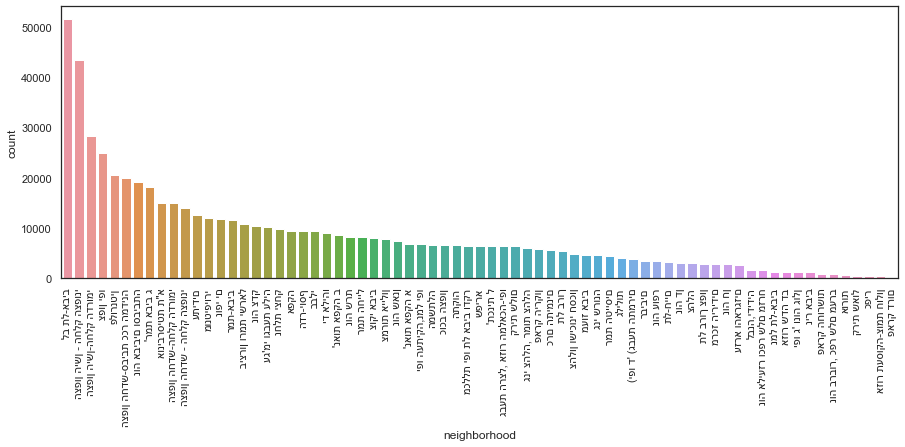

In [41]:
plt.figure(figsize=(15,5))
sns.barplot(x=nei_more_then['neighborhood'],y=nei_more_then['count'])
plt.xticks(rotation=90)
plt.yticks(np.arange(int(nei_more_then['count'].min()/1000)*1000, nei_more_then['count'].max(), 10000)) 
plt.xlabel("neighborhood")
plt.ylabel("count")